# Hierarchical clustering

We've looked at KMeans in an earlier project - what makes Hierarchical clustering different, and when would we use it? 

The problem with KMeans is that its clustering only works well if our data is organised into well separated hyperspheres. If that assumption doesn't hold true for some dataset we'd like to work on, then we need some other method of clustering.

Hierarchical clustering is designed for datasets that have some __hierarchy of links__ between observations, which we find to be true in many real world examples: a siamese cat is more similar to a tabby than to a dog, and both cats and dogs are more similar to each other than to parrots etc. It gives a tree based representation, also called a __dendrogram__, that separates our data hierarchically based on a specified distance measure, which may be the more conventional Manhattan and Euclidean distances, or any other measure of similarity/dissimilarity such as the Jaccard distance for word vectors, as used in Natural Language Processing. The implementation can be of either the Agglomerative (bottom-up) approach, or the Divisive (top-down) approach; generally the Agglomerative approach has a lower time complexity.

The __cophenetic distance__ is the measure of how similar two datapoints have to be in order to be grouped into the same cluster. The __cophenetic coefficient__ is a separate term: it is the metric that we use to measure how well the dendrogram from Hierarchical clustering preserves the pairwise distances between our data points. Similar to the silhouette coefficient, the cophenetic coefficient measures cluster fit, but it does so by calculating the correlation between the Euclidean distance matrix with the Cophenetic distance matrix. These terms come from biostatistics.

For this mini-project, we will load in a [dataset on crime statistics](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/USArrests.html).

### Loading libraries.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') 

### Exploratory Data Analysis

Here we'll load in the data, do a bit of cleaning, and use `pairplot()` to get a basic idea of the distribution of our data.

In [2]:
df = pd.read_csv('assets/mini/USArrests.csv')
df = df.rename(columns={'Unnamed: 0': 'States'})
print df.shape
df.head()

(50, 5)


,States,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


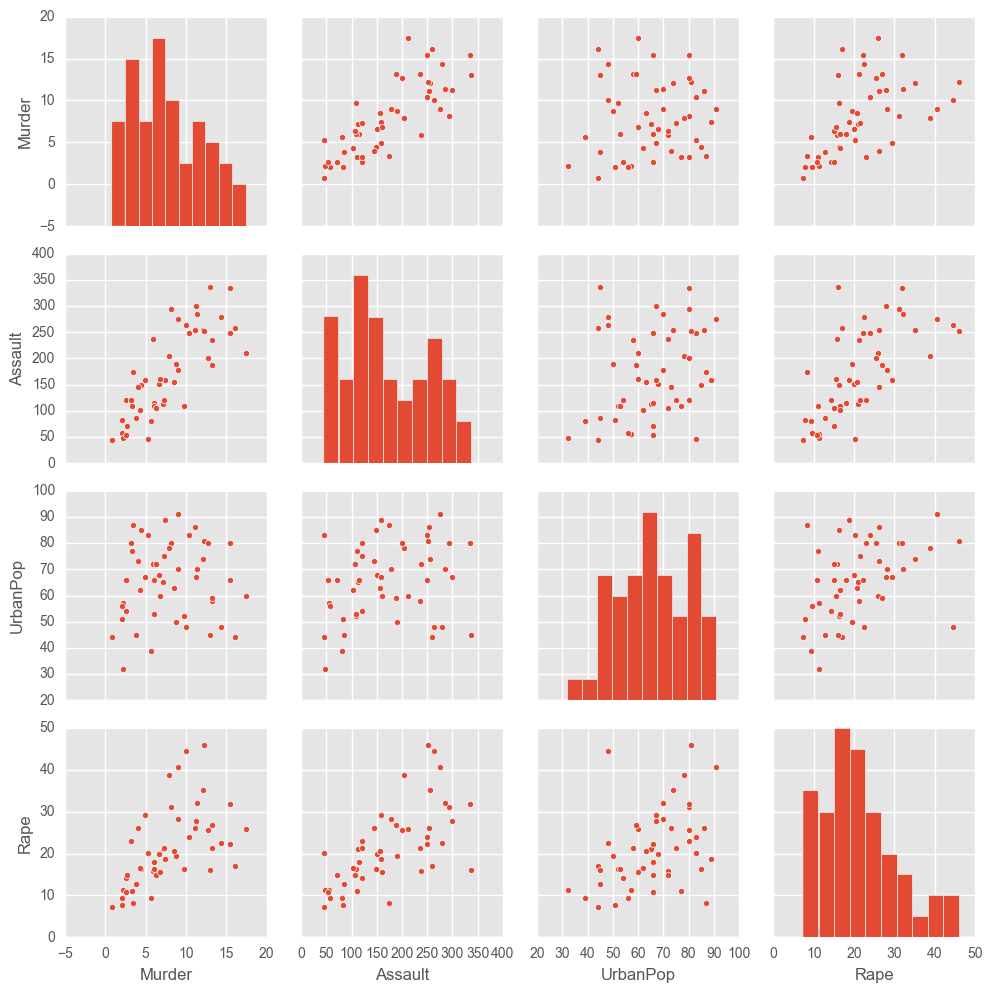

In [3]:
sns.pairplot(df)

### Standardisation.

Once more we call on `StandardScaler()` to help us preprocess the data prior to clustering.

In [4]:
ss = StandardScaler()
X_scaled = ss.fit_transform(df.iloc[:,1:])

### Principal Component Analysis.

A bit of a detour here using PCA - how well do our first two Principal Components explain the variance of the dataset?

In [5]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X_scaled)

In [6]:
print "The 1st principal component is:", pca.components_[0]
print "The 2nd principal component is:", pca.components_[1]

The 1st principal component is: [ 0.53589947  0.58318363  0.27819087  0.54343209]
The 2nd principal component is: [ 0.41818087  0.1879856  -0.87280619 -0.16731864]


In [7]:
print "The 1st principal component explains", pca.explained_variance_ratio_[0], "of the variance."
print "The 2nd principal component explains", pca.explained_variance_ratio_[1], "of the variance."
print "Together they explain", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1], "of the variance." 

The 1st principal component explains 0.620060394787 of the variance.
The 2nd principal component explains 0.247441288135 of the variance.
Together they explain 0.867501682922 of the variance.


It turns out 86.75% of the variance can be explained. We can say that the variance contains a lot of the information in our dataset!

### Hierarchical clustering. 

Working on the rescaled dataset, we now calculate the cophenetic correlation and distances, and plot the resulting dendrogram. Notice the `'ward'` argument we pass into `linkage()`. This is our __linkage criterion__ that takes the agglomerative approach, where the algorithm iteratively minimises the total in-cluster variance.

In [8]:
Z = linkage(X_scaled, 'ward')

In [9]:
c, cdoph_dists = cophenet(Z, pdist(X_scaled))

This is our cophenetic correlation coefficient.

In [10]:
c

0.69752656323703888

And this is our cophenetic distance matrix.

In [11]:
cdoph_dists

array([  6.52747083,   6.52747083,  13.6534666 , ...,   3.02367873,
         7.26116776,   7.26116776])

### Dendrogram.

We have 2 main clusters and their hierarchical relationship as visualised below, but it looks a bit cluttered doesn't it?

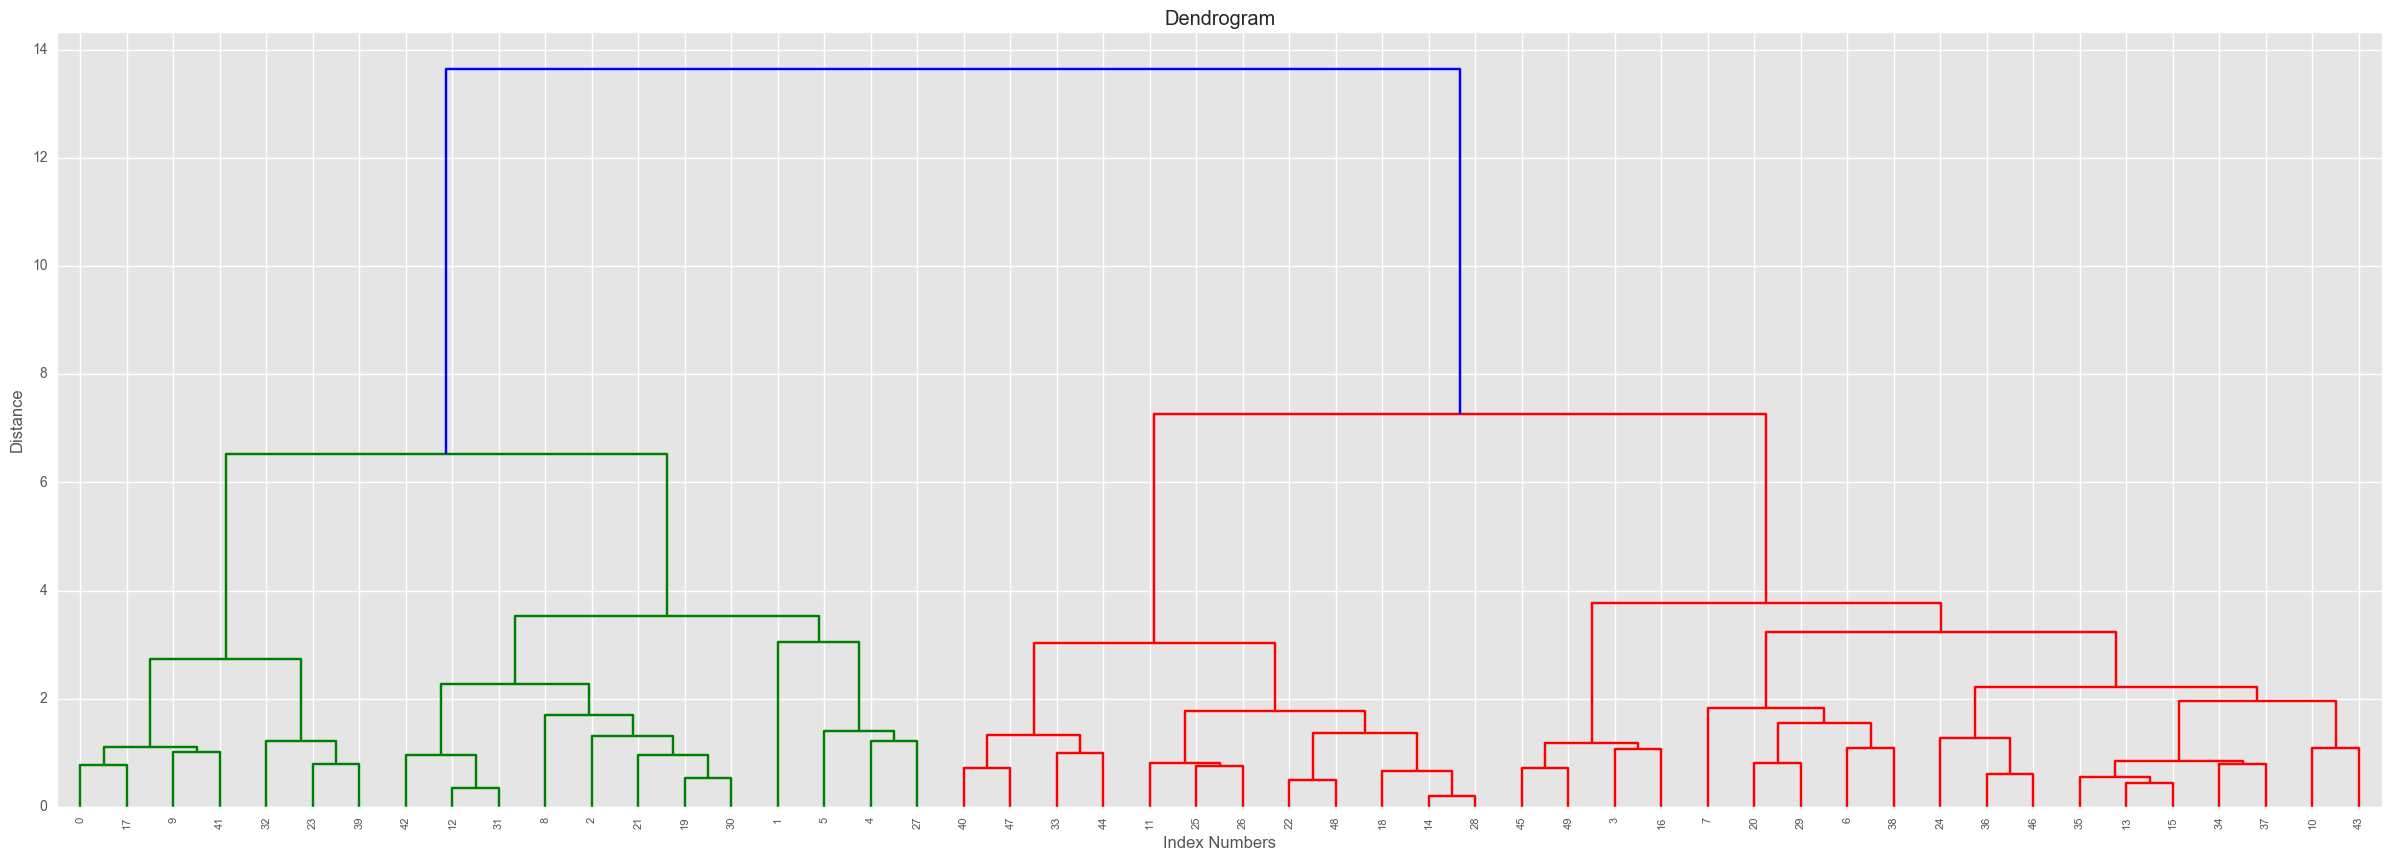

In [12]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

Using the keyword argument `truncate_mode`, we can do away with the bottom parts of the dendrogram to give us a clearer, simplified visualisation:

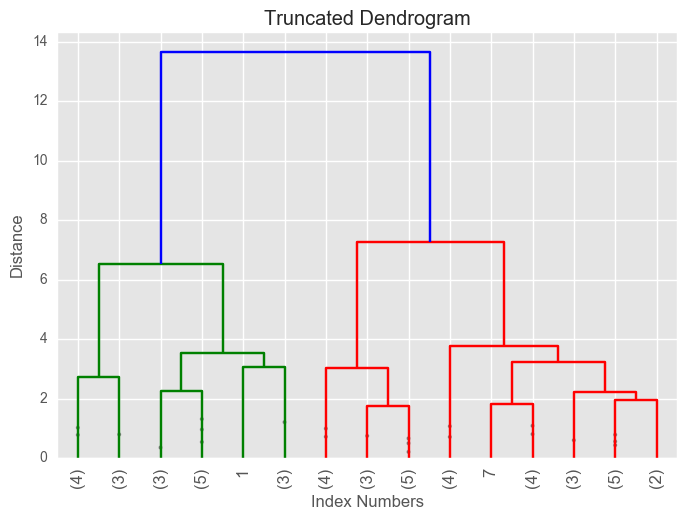

In [13]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=True,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

### Hierarchical clustering on two Principal Components.

Let's try this again on the two Principal Components we obtained through PCA earlier. Do the resulting clusters differ?

In [14]:
Z = linkage(df_pca, 'ward')

In [15]:
c, cdoph_dists = cophenet(Z, pdist(df_pca))

In [16]:
c

0.71900812390329116

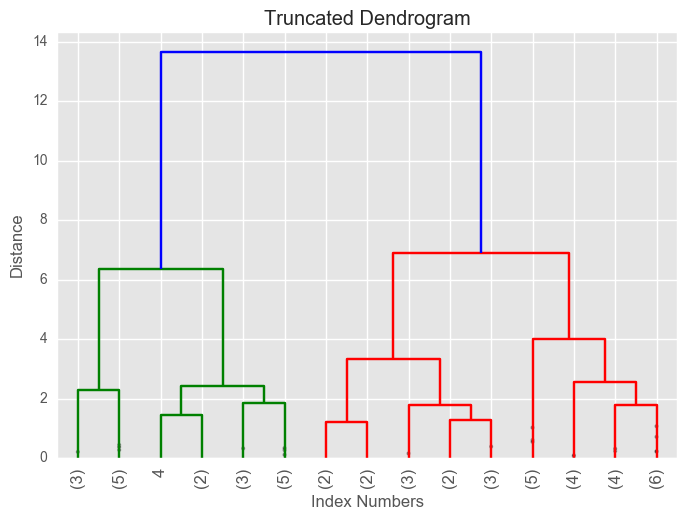

In [17]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=True,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

Although the dendrogram remains broadly similar, beyond the third split the exact clustering of points using 2 principal components differs from the clusters performed on all features. This is in line with our finding that the first two PCs explain 86.75% of the variance - a majority of the information in the original dataset is contained in these 2 PCs, we'd therefore expect the inherent structure that clustering discovers to remain broadly similar.

On the other hand, if we were to perform hierarchical clustering on PCs that poorly capture the original information, then we might expect the resulting clusters to be quite different.

### Varying the threshold.

The `fcluster` function allows us to pass in an argument `max_d` that we can use to __tune the number of clusters__. Intuitively, it is the threshold that cuts off one cluster from another. You can visualise it as a horizontal line on the dendrogram, above and below which we get different clusters. We make use of a for loop to test its effect on the number of clusters as the value changes from 1 to 10.

In [18]:
x_ = []
y_ = []
for i in range(1,11,1):
    max_d = i
    clusters = fcluster(Z, max_d, criterion='distance')
    x_.append(i)
    y_.append(len(set(clusters)))

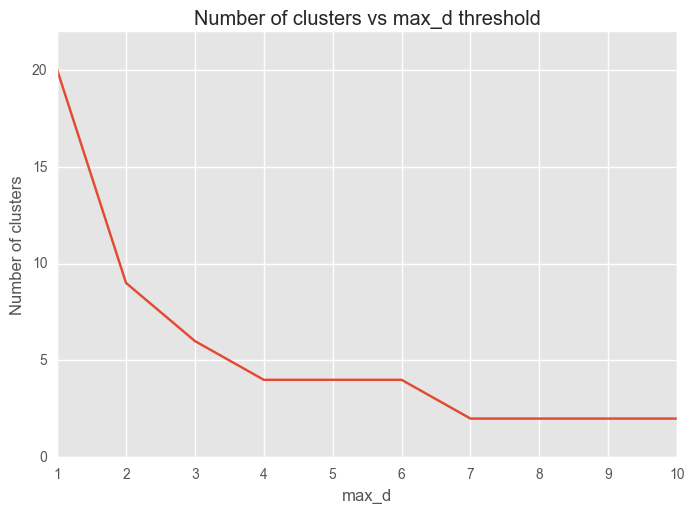

In [19]:
plt.plot(x_,y_)
plt.title("Number of clusters vs max_d threshold")
plt.xlabel("max_d")
plt.ylabel("Number of clusters")
plt.ylim(0, 22)
plt.xlim(1, 10)
plt.show()

### Visualising clusters of US states.

Let's take a step back and remind ourselves - this dataset is about US crime statistics among different states. Are there identifiable clusters of states? Let's see.

set([1, 2, 3, 4, 5, 6, 7, 8, 9])


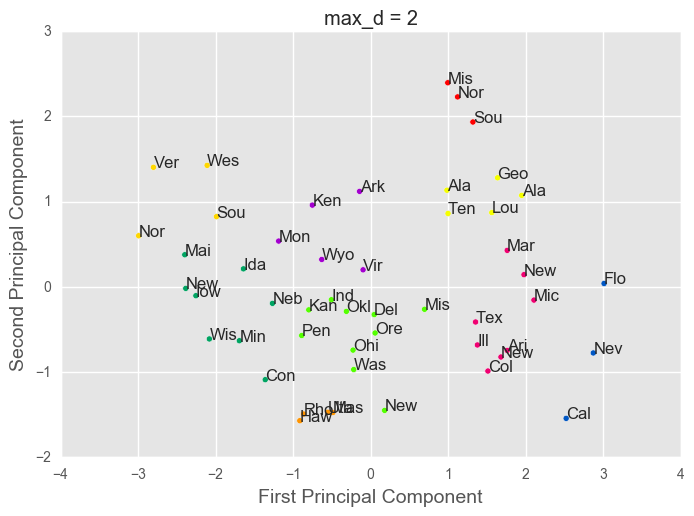

set([1, 2, 3, 4])


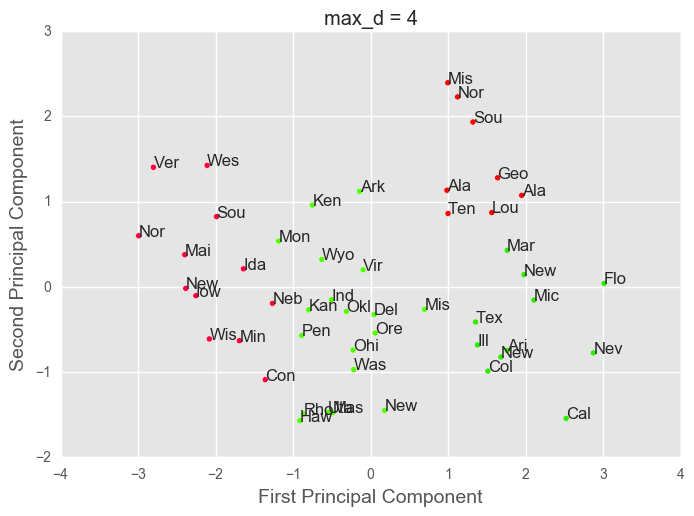

set([1, 2, 3, 4])


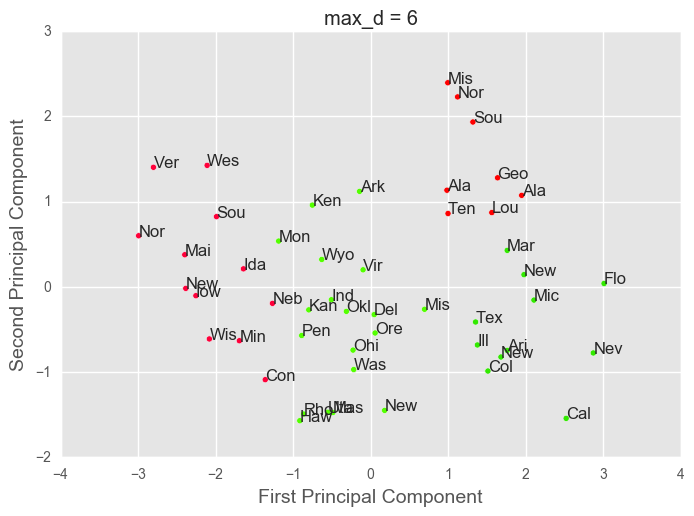

set([1, 2])


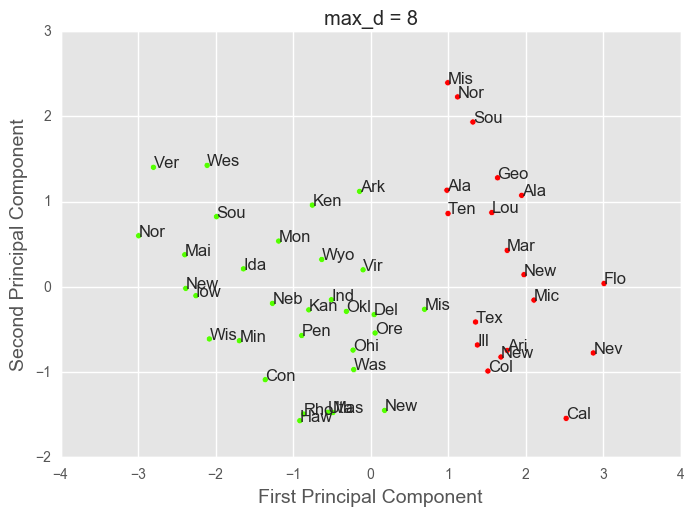

set([1, 2])


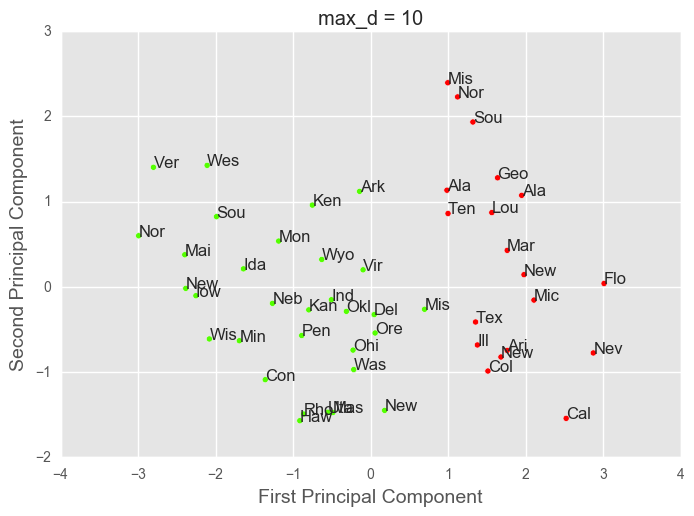

In [20]:
for i in range(2,12,2):
    max_d = i
    clusters = fcluster(Z, max_d, criterion='distance')
    print set(clusters)
    plt.scatter(df_pca[:,0], df_pca[:,1], c=clusters, cmap='prism')
    plt.title("max_d = "+str(i))
    for i, x_i in enumerate(df['States']):
        plt.annotate(x_i[:3], (df_pca[i,0], df_pca[i,1]), fontsize=12)
    plt.xlabel('First Principal Component',fontsize=14)
    plt.ylabel('Second Principal Component',fontsize=14)
    plt.show()